# <h1><center>Time Series Forecasting</center></h1>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa as ts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools as stt

In [2]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

### Analyzing the Data

In [3]:
sales_df = pd.read_csv("./data/data/train.csv",encoding="ISO-8859-1")

In [4]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
len(pd.unique(sales_df['Store']))

1115

In [6]:
sales_df.loc[sales_df.Store == 1 ].sort_values(by=['Date'])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1
...,...,...,...,...,...,...,...,...,...
4460,1,1,2015-07-27,6102,612,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1


In [7]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Validating the different columns and their data

In [8]:
sales_df.DayOfWeek.unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [9]:
sales_df.Open.unique()

array([1, 0], dtype=int64)

In [10]:
sales_df.Promo.unique()

array([1, 0], dtype=int64)

In [11]:
sales_df.SchoolHoliday.unique()

array([1, 0], dtype=int64)

In [12]:
sales_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [13]:
sales_df[sales_df.StateHoliday == 0].StateHoliday.count()

131072

In [14]:
sales_df[sales_df.StateHoliday == '0'].StateHoliday.count()

855087

#### Removing the additional zero records in StateHoliday column to correct the values

In [15]:
sales_df.loc[sales_df.StateHoliday == 0,'StateHoliday'] = "0"

In [16]:
sales_df[sales_df.StateHoliday == 0].StateHoliday.count()

0

In [17]:
sales_df[sales_df.StateHoliday == "0"].StateHoliday.count()

986159

### Since 'a','b','c','d' show state holiday and 0 show no holiday , we will map our column to show same numerically

In [19]:
sales_df["StateHoliday"] = sales_df["StateHoliday"].map({"0": 0, "a": 1, "b": 2, "c": 3})

In [20]:
sales_df.StateHoliday.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

In [21]:
sales_df["Sales"].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

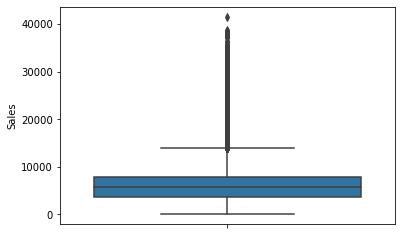

In [22]:
sns.boxplot(y =sales_df["Sales"])
plt.show()

### We can see there are some outliers present at the top

In [23]:
sales_df.Sales.quantile(0.99)

17160.0

In [24]:
sales_df.Sales.max()

41551

In [25]:
sales_df.Sales.count()

1017209

In [26]:
sales_df[sales_df.Sales >= sales_df.Sales.quantile(0.99)].Sales.count()

10178

###  ---Removing outliers at 99th percentile
### <span style='background:yellow'> We are now going to remove the outliers individually at the store level when we generate predictions for them</span>

In [27]:
#sales_df = sales_df[sales_df.Sales < sales_df.Sales.quantile(0.99)]

In [28]:
#sales_df.Sales.count()

### Feature Creation

#### Adding columns for the year and month

In [29]:
sales_df['Month'] = pd.DatetimeIndex(sales_df["Date"]).month

In [30]:
sales_df['Year'] = pd.DatetimeIndex(sales_df["Date"]).year

In [31]:
sales_df['Day'] = pd.DatetimeIndex(sales_df["Date"]).day

In [32]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,7,2015,31
1,2,5,2015-07-31,6064,625,1,1,0,1,7,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,7,2015,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,2015,31
4,5,5,2015-07-31,4822,559,1,1,0,1,7,2015,31


In [33]:
sales_df[sales_df.Open == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Day
291,292,5,2015-07-31,0,0,0,1,0,1,7,2015,31
875,876,5,2015-07-31,0,0,0,1,0,1,7,2015,31
1406,292,4,2015-07-30,0,0,0,1,0,1,7,2015,30
1990,876,4,2015-07-30,0,0,0,1,0,1,7,2015,30
2521,292,3,2015-07-29,0,0,0,1,0,1,7,2015,29
...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,1,2013,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,1,2013,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,1,2013,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1,1,2013,1


### Therefore zero sales as the store is closed

#### Plotting Correlation matrix

In [34]:
corrMatrix = sales_df.corr()

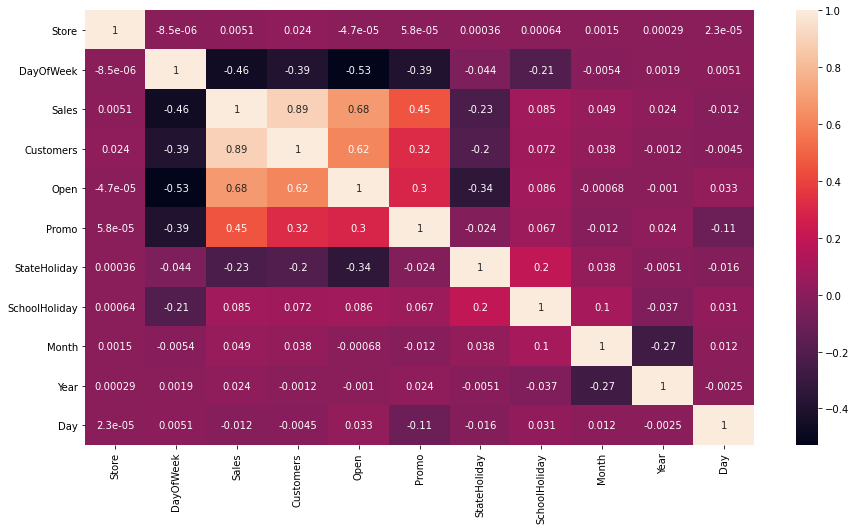

In [35]:
plt.figure(figsize=(15,8)) 
sns.heatmap(corrMatrix, annot=True)
plt.show()

### We see high correlation between sales and customers and sales and Store Open.

### Getting the Store information

In [36]:
store_df = pd.read_csv("./data/data/store.csv",encoding="ISO-8859-1")

In [37]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [38]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [39]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [40]:
store_df.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [41]:
print(store_df[store_df.Promo2 == 0].PromoInterval.isnull().count())
print(store_df[store_df.Promo2 == 0].Promo2SinceWeek.isnull().count())
print(store_df[store_df.Promo2 == 0].Promo2SinceYear.isnull().count())


544
544
544


### We can see all the null values for Promo related columns are null when the store is not participating in Promotion , therefore we can substitute 0 for that

In [42]:
store_df.loc[store_df.Promo2 == 0,['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

### Changing the categorical values to numerical values

In [43]:
store_df["PromoInterval"] = store_df["PromoInterval"].map({0: 0, "Jan,Apr,Jul,Oct": 1, "Feb,May,Aug,Nov": 2, "Mar,Jun,Sept,Dec": 3})

In [44]:
store_df.PromoInterval.unique()

array([0, 1, 2, 3], dtype=int64)

In [45]:
store_df.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [46]:
store_df["StoreType"] = store_df["StoreType"].map({"a": 0, "b": 1, "c": 2, "d": 3})

In [47]:
store_df.StoreType.unique()

array([2, 0, 3, 1], dtype=int64)

In [48]:
store_df.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [49]:
store_df["Assortment"] = store_df["Assortment"].map({"a": 0, "b": 1, "c": 2})

In [50]:
store_df.Assortment.unique()

array([0, 2, 1], dtype=int64)

In [51]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0


In [52]:
store_df[store_df.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,0,2,1070.0,NaN,NaN,1,13.0,2010.0,1
12,13,3,0,310.0,NaN,NaN,1,45.0,2009.0,2
15,16,0,2,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,0,2,3240.0,NaN,NaN,1,22.0,2011.0,3
21,22,0,0,1040.0,NaN,NaN,1,22.0,2012.0,1
...,...,...,...,...,...,...,...,...,...,...
1095,1096,0,2,1130.0,NaN,NaN,1,10.0,2014.0,3
1099,1100,0,0,540.0,NaN,NaN,1,14.0,2011.0,1
1112,1113,0,2,9260.0,NaN,NaN,0,0.0,0.0,0
1113,1114,0,2,870.0,NaN,NaN,0,0.0,0.0,0


In [53]:
store_df.CompetitionOpenSinceMonth.unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

### It's hard to infer any meaningful information from just store data at this point, so Let's merge them with Sales data

In [54]:
fullData_df = pd.merge(sales_df,store_df,how = "left" ,on="Store")

In [55]:
fullData_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,31,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,31,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,31,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,31,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,31,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0


In [56]:
sales_df.count()

Store            1017209
DayOfWeek        1017209
Date             1017209
Sales            1017209
Customers        1017209
Open             1017209
Promo            1017209
StateHoliday     1017209
SchoolHoliday    1017209
Month            1017209
Year             1017209
Day              1017209
dtype: int64

In [57]:
store_df.CompetitionOpenSinceMonth.isnull().sum()

354

In [58]:
fullData_df[fullData_df.CompetitionOpenSinceMonth.isnull()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,5,2015-07-31,8959,962,1,1,0,1,7,...,31,0,2,1070.0,NaN,NaN,1,13.0,2010.0,1
12,13,5,2015-07-31,8821,568,1,1,0,0,7,...,31,3,0,310.0,NaN,NaN,1,45.0,2009.0,2
15,16,5,2015-07-31,10231,979,1,1,0,1,7,...,31,0,2,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,5,2015-07-31,8234,718,1,1,0,1,7,...,31,0,2,3240.0,NaN,NaN,1,22.0,2011.0,3
21,22,5,2015-07-31,6566,633,1,1,0,0,7,...,31,0,0,1040.0,NaN,NaN,1,22.0,2012.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017189,1096,2,2013-01-01,0,0,0,0,1,1,1,...,1,0,2,1130.0,NaN,NaN,1,10.0,2014.0,3
1017193,1100,2,2013-01-01,0,0,0,0,1,1,1,...,1,0,0,540.0,NaN,NaN,1,14.0,2011.0,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,1,...,1,0,2,9260.0,NaN,NaN,0,0.0,0.0,0
1017207,1114,2,2013-01-01,0,0,0,0,1,1,1,...,1,0,2,870.0,NaN,NaN,0,0.0,0.0,0


In [59]:
fullData_df[( fullData_df.CompetitionOpenSinceMonth.isnull() ) & ( fullData_df["CompetitionDistance"] == 0) ]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


### We still don't see any meaningful value , so let's impute them with dummy values

In [60]:
fullData_df["CompetitionOpenSinceYear"][fullData_df["CompetitionOpenSinceYear"].isnull()] = 1900


In [61]:
fullData_df["CompetitionOpenSinceMonth"][fullData_df["CompetitionOpenSinceMonth"].isnull()] = 1

### Creating some new features

In [64]:
fullData_df['CompetitionOpenMonth'] = 12 * (fullData_df.Year - fullData_df.CompetitionOpenSinceYear) + (fullData_df.Month - fullData_df.CompetitionOpenSinceMonth)

In [67]:
fullData_df['Date'] = pd.to_datetime(fullData_df['Date'])

In [68]:
fullData_df['WeekOfYear'] = fullData_df.Date.dt.weekofyear

In [69]:
fullData_df['PromoOpenMonths'] = 12 * (fullData_df.Year - fullData_df.Promo2SinceYear) + (fullData_df.WeekOfYear - fullData_df.Promo2SinceWeek) / 4.0

In [70]:
fullData_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenMonth,WeekOfYear,PromoOpenMonths
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,31,24187.75
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,570.0,11.0,2007.0,1,13.0,2010.0,1,92.0,31,64.50
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,14130.0,12.0,2006.0,1,14.0,2011.0,1,103.0,31,52.25
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,620.0,9.0,2009.0,0,0.0,0.0,0,70.0,31,24187.75
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,29910.0,4.0,2015.0,0,0.0,0.0,0,3.0,31,24187.75


In [71]:
fullData_df.loc[fullData_df.Promo2SinceYear == 0, 'PromoOpenMonths'] = 0

In [72]:
fullData_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenMonth,WeekOfYear,PromoOpenMonths
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,31,0.00
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,570.0,11.0,2007.0,1,13.0,2010.0,1,92.0,31,64.50
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,14130.0,12.0,2006.0,1,14.0,2011.0,1,103.0,31,52.25
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,620.0,9.0,2009.0,0,0.0,0.0,0,70.0,31,0.00
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,29910.0,4.0,2015.0,0,0.0,0.0,0,3.0,31,0.00


In [73]:
fullData_df['PromoOpenMonths'] = fullData_df.PromoOpenMonths.apply(lambda x: x if x > 0 else 0)

In [74]:
fullData_df['CompetitionOpenMonth'] = fullData_df.CompetitionOpenMonth.apply(lambda x: x if x > 0 else 0)

In [75]:
corrMatrix = fullData_df.corr()

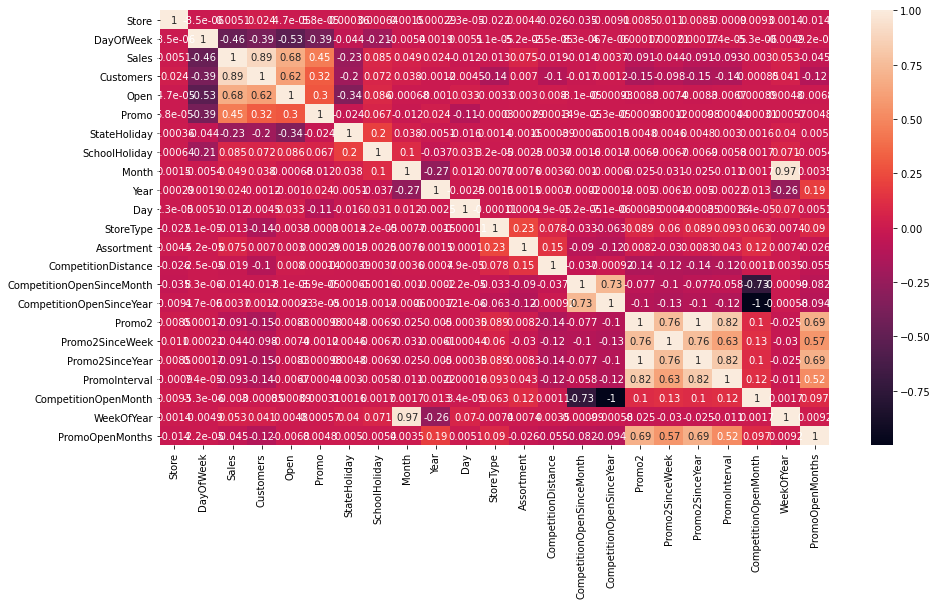

In [76]:
plt.figure(figsize=(15,8)) 
sns.heatmap(corrMatrix, annot=True)
plt.show()

### We don't have additional coorelations other than the columns and corresponding new derived columns

In [77]:
fullData_df['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [78]:
day_of_Week_df = pd.get_dummies(fullData_df['DayOfWeek']).rename(columns=lambda x: 'DayOfWeek_' + str(x))

In [79]:
day_of_Week_df

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
1017204,0,1,0,0,0,0,0
1017205,0,1,0,0,0,0,0
1017206,0,1,0,0,0,0,0
1017207,0,1,0,0,0,0,0


In [80]:
fullData_df = pd.concat([fullData_df, day_of_Week_df], axis=1)

In [82]:
fullData_df.drop(['DayOfWeek'], inplace=True, axis=1)

In [83]:
fullData_df.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,...,CompetitionOpenMonth,WeekOfYear,PromoOpenMonths,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1,2015-07-31,5263,555,1,1,0,1,7,2015,...,82.0,31,0.00,0,0,0,0,1,0,0
1,2,2015-07-31,6064,625,1,1,0,1,7,2015,...,92.0,31,64.50,0,0,0,0,1,0,0
2,3,2015-07-31,8314,821,1,1,0,1,7,2015,...,103.0,31,52.25,0,0,0,0,1,0,0
3,4,2015-07-31,13995,1498,1,1,0,1,7,2015,...,70.0,31,0.00,0,0,0,0,1,0,0
4,5,2015-07-31,4822,559,1,1,0,1,7,2015,...,3.0,31,0.00,0,0,0,0,1,0,0


##  <font color =green> Model Preparation Steps</font>

### Creating Various functions to keep the Actual model executions steps more readable

In [84]:
def preprocessData(df , store = 1 ) :
    """
    Create the dataset for the store number passed 
    and return the dataset
    """
    
    storeDataOne=df.loc[df["Store"]==store]
    storeDataOne=storeDataOne.reset_index(drop=True)
    
    ### Removing the records when the store was closed as it gives bad forecast results.
    storeDataOne = storeDataOne[storeDataOne.Open != 0]
    
    ### Also removing the Outliers at the individual store level
    storeDataOne = storeDataOne[storeDataOne.Sales < storeDataOne.Sales.quantile(0.99)]
    
    return storeDataOne

In [85]:
def addingSeasonalTrends(df,view =False) :
    """
    Return the dataframe after appending the seasonal trends
    View to view the Seasonality and Trend plots generated on Sales and Customer Series
    Change the index of the dataframe for further usage
    """
    ### For Sales data
    result = seasonal_decompose((df.iloc[:,2]), model='additive', freq=305, extrapolate_trend='freq')
    ## View the seasonal decoposition plots
    if view :
        result.plot()
    
    ### appending the trends
    df["SalesSeasonality"]=result.seasonal
    df["SalesTrend"]=result.trend
    
    ### For Customers data
    result = seasonal_decompose((df.iloc[:,3]), model='additive', freq=305, extrapolate_trend='freq')
    ## View the seasonal decoposition plots
    if view :
        result.plot()
    
    df["CustSeasonality"]=result.seasonal
    df["CustTrend"]=result.trend
    
    ### Also change the index to be used for the dataframe
    df['datetime'] = pd.to_datetime(df['Date'])
    df = df.set_index('datetime')
    df.drop(['Date'], axis=1, inplace=True)
    #df.head()
    
    return df

In [280]:
### Split into test and Train sets
def splitData(df ,nobs = 0) :
    """
    Split the dataset into train and test set based on the len of the passed data
    Return different sets of the test and train data sets
    """
    ### finding the cutoff for splitting the data
    if nobs == 0 :
        round(len(df)*.20)
    else :
        nobs = nobs
    
    ## creating the test and train datasets
    df_train, df_test = df[0:-nobs], df[-nobs:]
    
    ### Also splitting into endogenous and exogenous test and train sets
    
    ### Train
    endog = df_train[['Sales', 'Customers']].astype('float32')
    exog = df_train[['Promo', 'SchoolHoliday',
                        'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
                        'DayOfWeek_4','DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_1', 'SalesSeasonality',
                        'SalesTrend', 'CustSeasonality', 'CustTrend']].astype('float32')
    
    ##  Test
    endog_test = df_test[['Sales', 'Customers']].astype('float32')
    exog_test = df_test[['Promo', 'SchoolHoliday',
                        'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
                        'DayOfWeek_4','DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_1', 'SalesSeasonality',
                        'SalesTrend', 'CustSeasonality', 'CustTrend']].astype('float32')

    
    
    return df_train,df_test ,endog , exog ,endog_test ,exog_test

In [153]:
### Create Reporting dataset for VAR model
def reportVAR(endog_test,df_results):
    """
    Create the data frames that will be used to plot the forecasts for VAR MODEL
    """
    actual1=endog_test.copy(deep=True) 
    actual1.rename(columns = {'Sales':'Actual_Sales', 'Customers':'Actual_Customers'}, inplace = True) 
    
    pred = df_results[['Sales_forecast','Customers_forecast']]
    pred.rename(columns = {'Sales_forecast':'Sales', 'Customers_forecast':'Customers'}, inplace = True) 
        
    combined = pd.merge(actual1, pred, right_index=True, left_index=True)
     
    
    return combined

In [88]:
def reportVARMAX(endog_test,forcast):
    """
    Create the data frames that will be used to plot the forecasts
    """
    actual1=endog_test.copy(deep=True) 
    actual1 = actual1.reset_index(drop=True)
    actual1.rename(columns = {'Sales':'Actual_Sales', 'Customers':'Actual_Customers'}, inplace = True) 
    
    pred = forcast.copy(deep=True) 
    pred = pred.reset_index(drop=True)
    
    combined = pd.merge(actual1, pred, right_index=True, left_index=True)
     
    
    return combined

In [89]:
def plotForecastVAR(endog_test,df_results) :
    """
    Plot the graph for VAR Test results 
    """
    # adjust figure size
    plt.figure(figsize=(15, 10))
    
    # subplot 1:Sales
    plt.subplot(1, 2, 1)
    plotData = reportVAR(endog_test,df_results)
    plotData = plotData[plotData.Actual_Sales != 0]
    
    plt.title("Sales: Forecast vs Actuals")
    plt.plot(plotData['Actual_Sales'], color='blue')
    plt.plot(plotData['Sales'], color='red')
    
    
    # subplot 2: Customers
    plt.subplot(1, 2, 2)
    plotData2= reportVAR(endog_test,df_results)
    plotData2 = plotData2[plotData2.Actual_Customers != 0]
    
    plt.title("Customers: Forecast vs Actuals")
    plt.plot(plotData['Actual_Customers'], color='blue')
    plt.plot(plotData['Customers'], color='red')
    
    
    ### show the plot
    plt.show()

In [90]:
def plotForecastVARMAX(endog_test,forcast) :
    """
    Plot the graph for Test results for VARMAX
    These two models have the different result resulting from the model output therefore separate functions
    Also we want to show the 0 Sales and 0 Customers separately
    """
    # adjust figure size
    plt.figure(figsize=(15, 10))
    
    # subplot 1:Sales
    plt.subplot(1, 2, 1)
    plotData = reportVARMAX(endog_test,forcast)
    plotData = plotData[plotData.Actual_Sales != 0]
    
    plt.title("Sales: Forecast vs Actuals")
    plt.plot(plotData['Actual_Sales'], color='blue')
    plt.plot(plotData['Sales'], color='red')
    
    
    # subplot 2: Customers
    plt.subplot(1, 2, 2)
    plotData2= reportVARMAX(endog_test,forcast)
    plotData2 = plotData2[plotData2.Actual_Customers != 0]
    
    plt.title("Customers: Forecast vs Actuals")
    plt.plot(plotData['Actual_Customers'], color='blue')
    plt.plot(plotData['Customers'], color='red')
    
    
    ### show the plot
    plt.show()

In [91]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [92]:
### Will pass only the Sales and customer series of one store for the cointegration test

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)



In [93]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report
    this will accept the series which we want to test for the stationarity
    e.g. df_train[['Sales','Customers']]
    This will return True if series is stationary else False
    """
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
     

In [221]:
def invert_transformation(endog_test, df_forecast,no_diff =False , second_diff=False,first_diff=False):
    """Revert back the differencing to get the forecast to original scale.
        Here we are assuming only two levels of differences. 
        If there is no difference it will return the original dataframe
     """
    df_fc = df_forecast.copy(deep =True)
    columns = endog_test.columns
    for col in columns:     
        ### if there was no differencing done 
        if no_diff :
            df_fc[str(col)+'_forecast'] = df_fc[str(col)]
            
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_forecast'] = (endog_test[col].iloc[-1]-endog_test[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        if first_diff:
            df_fc[str(col)+'_forecast'] = endog_test[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
        
        
        
    return df_fc

In [223]:
def invert_transformationVARMAX(endog_test, df_forecast,no_diff =False , second_diff=False,first_diff=False):
    """Revert back the differencing to get the forecast to original scale.
        Here we are assuming only two levels of differences. 
        If there is no difference it will return the original dataframe
     """
    df_fc = df_forecast.copy(deep =True)
    df_fc = df_fc.reset_index(drop=True)
    endog_Test1 = endog_test.copy(deep=True)
    endog_Test1 = endog_Test1.reset_index(drop=True)
    columns = endog_Test1.columns
    for col in columns:     
        ### if there was no differencing done 
        if no_diff :
            df_fc[str(col)+'_forecast'] = df_fc[str(col)]
            
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_forecast'] = (endog_Test1[col].iloc[-1]-endog_Test1[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        if first_diff:
            df_fc[str(col)+'_forecast'] = endog_Test1[col].iloc[-1] + df_fc[str(col)].cumsum()
        
        
        
    return df_fc

### VAR Model

In [95]:
def callVARModel(endog,endog_test, notDifferenced = True,oneDifferenced=False):
    """
    endog : train set with only the Series 
    endo_test : Test set to be used for calculating the forecasted values
    notDifferenced: if the series is differenced
    oneDifferenced : if the series is differenced one time
    """
    model = VAR(endog)
    
    x = model.select_order()
    lags = x.aic
    #x.summary()
    model_fitted = model.fit(lags)
    print(model_fitted.summary())
    
    # Step 5 : Calculate lag order
    lag_order =model_fitted.k_ar
    
    # Step 6 : Calculating the shape of forecast input 
    forecast_input = endog.values[-lag_order:]
    forecast_input.shape
    
    # Step 7 : Calculating the actual forecast value 
    if notDifferenced :
        strAppend = ""
    elif oneDifferenced :
        strAppend = "_1d"
    else :
        strAppend = "_2d"
        
    nobs = len(endog_test)
        
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=endog_test.index[-nobs:], columns=endog_test.columns + strAppend)
    df_forecast
    
    return df_forecast    

In [96]:
def callVARMAXModel(endog,exog,endog_test,exog_test,maxiteration =100):
    """
    df : train set with only the Series 
    differenced: if the series is differenced
    We are giving a standard order , usually the lags in the series are visible till at least 15 so we are using 18
    """
    model =  VARMAX(endog,order=(18,0), trend='n', exog=exog)
    
    res = model.fit(maxiter=maxiteration)
    print(res.summary())
    
    # Step 5 : Calculating the shape of forecast input 
    forcast=res.forecast(steps=len(endog_test), exog=exog_test)
    irf=res.impulse_responses(steps=100, orthogonalized=False)
    
    return forcast ,irf    
    

## Steps to be done to find the forecast

In [ ]:
### Steps to be done to find the forecast
# 1) Create a subset of data for one store and get final endogenous and exogenous set after data preprocessing 
# 2) Check the Causality between the variables and see if any one of them is significant( < .05)
# 3) Check for Johannsen Cointegration test to see if there are any cointegration between the series.
# 4) Check for ADF Test to check for stationarity and continue to 5 if stationary otherwise:
#   a) get a differenced series
#   b) repeat the process 4 again
# 5) Call the VAR or VARMAX model based on the Stationary test
# 6) Plot the graph of the forecasted results and actuals on Test data.
# 7) Find the MAPE values for forecasted values.


# These steps will be repeated for different stores. Since in our dataset we have 1115 stores we are only going to showcase 
# few stores. (These entire steps can be combined into a function as we already have created separate functions for most
#  but we are going to do this in steps to show the process)



## <font color =Maroon> Step 1 : Preprocessing the data</font>

In [269]:
storeDataAll = preprocessData(fullData_df,store =1)

In [270]:
len(storeDataAll)

773

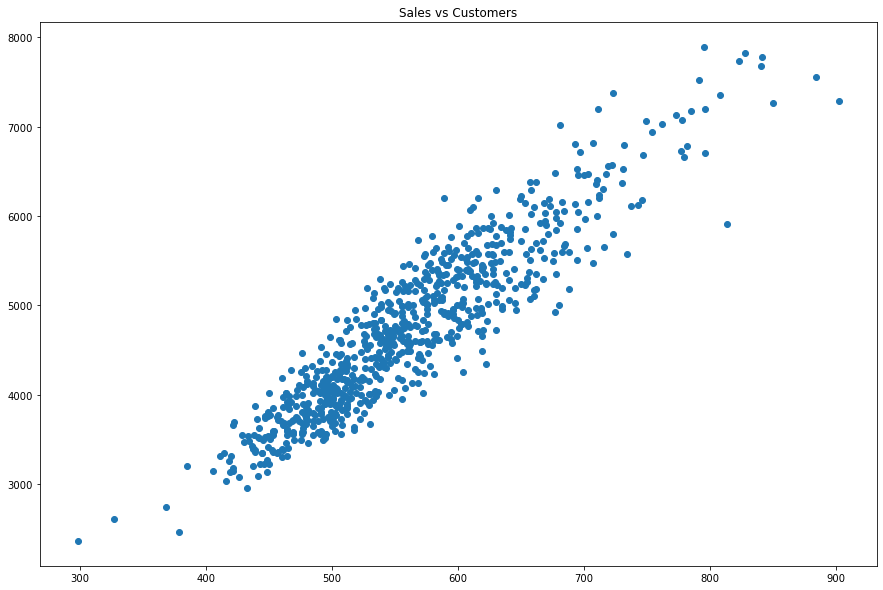

In [273]:
plt.figure(figsize=(15, 10))

plt.title("Sales vs Customers")
plt.scatter(storeDataAll['Customers'],storeDataAll['Sales'])
plt.show()

### This is as expected where we have sort of linear relationship between Sales and Customers

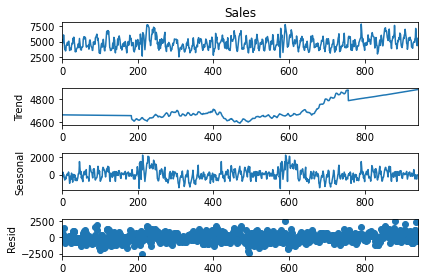

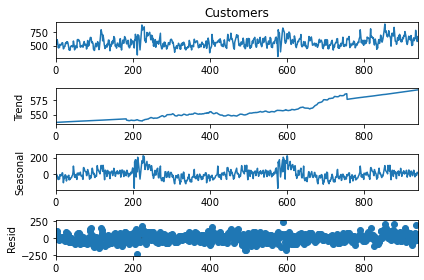

In [99]:
storeDataAll = addingSeasonalTrends(storeDataAll,view =True)

In [100]:
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataAll)

### <font color = Maroon> Step 2 : Check the Causality </font>

In [101]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [104]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataAll, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [105]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  157.86    > 12.3212   =>   True
Customers ::  0.08      > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [106]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1758
 No. Lags Chosen       = 13
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.097
 No. Lags Chosen       = 13
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.001. Rejecting Null Hypothesis.
 => Series is Stationary.




In [ ]:
########## Diff if needed to be used
    endogdiff=endog.diff().dropna()
    exogdiff=exog.diff().dropna()
    endogdiff_test=endog_test.diff().dropna()
    exogdiff_test=exog_test.diff().dropna()

### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [107]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endog,endog_test, notDifferenced=True,oneDifferenced=False)
###    df_forecast =callVARModel(endogdiff,endogdiff_test, notDifferenced=False,oneDifferenced=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     20:29:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.8418
Nobs:                     604.000    HQIC:                   19.5835
Log likelihood:          -7520.61    FPE:                2.71405e+08
AIC:                      19.4190    Det(Omega_mle):     2.47106e+08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               800.771676       333.997874            2.398           0.017
L1.Sales              0.715636         0.096498            7.416           0.000
L1.Customers         -1.683871         1.075551           -1

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [108]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =True, second_diff=False,first_diff=False) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

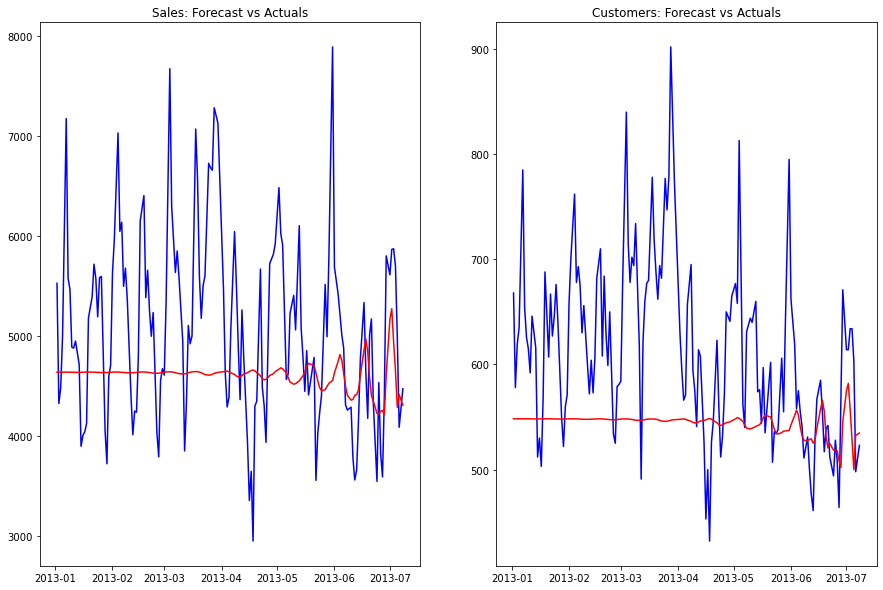

In [109]:
plotForecastVAR(endog_test,df_results)

 ### <font color =Maroon>Step 8 : Find the MAPE</font>

In [110]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [111]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.14340981715623158


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [112]:
forcast ,irf  = callVARMAXModel(endog,exog,endog_test,exog_test ,maxiteration =100)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  618
Model:                           VARX(18)   Log Likelihood               -7388.981
Date:                    Mon, 28 Dec 2020   AIC                          14979.962
Time:                            20:32:36   BIC                          15427.037
Sample:                                 0   HQIC                         15153.769
                                    - 618                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            16.73, 1.81   Jarque-Bera (JB):         395.11, 1.46
Prob(Q):                        0.00, 0.18   Prob(JB):                   0.00, 0.48
Heteroskedasticity (H):         0.92, 0.83   Skew:                      0.56, -0.01
Prob(H) (two-sided):            0.54, 0.17   Kurtosis:                   6.76, 3.24


### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

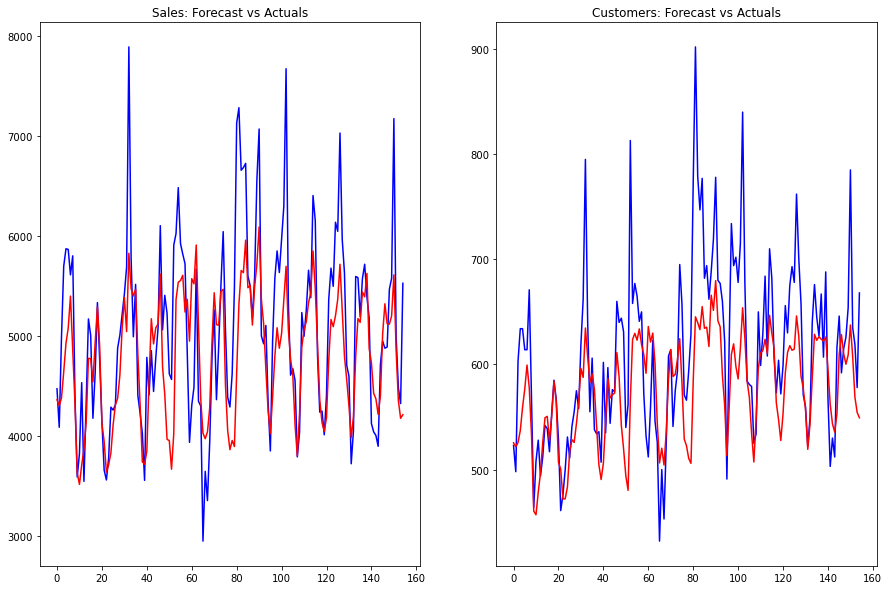

In [113]:
plotForecastVARMAX(endog_test,forcast)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [114]:
report_data= reportVARMAX(endog_test,forcast)
report_data = report_data[report_data.Actual_Sales != 0]

In [115]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

0.09257402959822031


### We are getting lot better results for VARMAX that VAR for the Store 1 

### <font color =Maroon>VARMAX allows us to check for the IRF as well</font>

<AxesSubplot:>

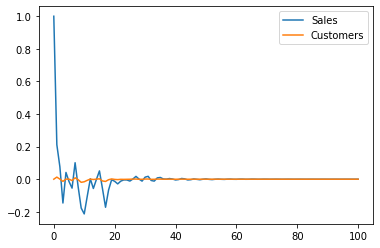

In [116]:
irf.plot()

#### Since the graph is returning to zero for both Sales and Customers we can conclude that there are no long term relationship between the two

## <font color =Green>Running the Process Again for another Store : 232</font>

### <font color =Maroon> Step 1 : Preprocessing the data </font>

In [117]:
### Getting data for one store
storeDataOne = preprocessData(fullData_df,store =232)

In [118]:
len(storeDataOne)

758

In [119]:
### Adding Seasonality and  trends
storeDataOne = addingSeasonalTrends(storeDataOne,view =False)

In [120]:
### Splitting the data into test sets
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataOne)

### <font color =Maroon> Step 2 : Check the Causality </font>

In [121]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [122]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataOne, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


In [123]:
### Since we can see the p-values are less than .05 the Sales is causing Customers and Customers is causing Sales.

### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [124]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  119.73    > 12.3212   =>   True
Customers ::  0.13      > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [125]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8794
 No. Lags Chosen       = 15
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1448
 No. Lags Chosen       = 13
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0008. Rejecting Null Hypothesis.
 => Series is Stationary.




### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [126]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endog,endog_test, notDifferenced=True,oneDifferenced=False)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     20:33:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.6042
Nobs:                     592.000    HQIC:                   19.3420
Log likelihood:          -7297.73    FPE:                2.12585e+08
AIC:                      19.1747    Det(Omega_mle):     1.93194e+08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               832.168142       368.143429            2.260           0.024
L1.Sales              0.043074         0.111062            0.388           0.698
L1.Customers          2.661000         1.628965            1

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [127]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =True, second_diff=False,first_diff=False) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

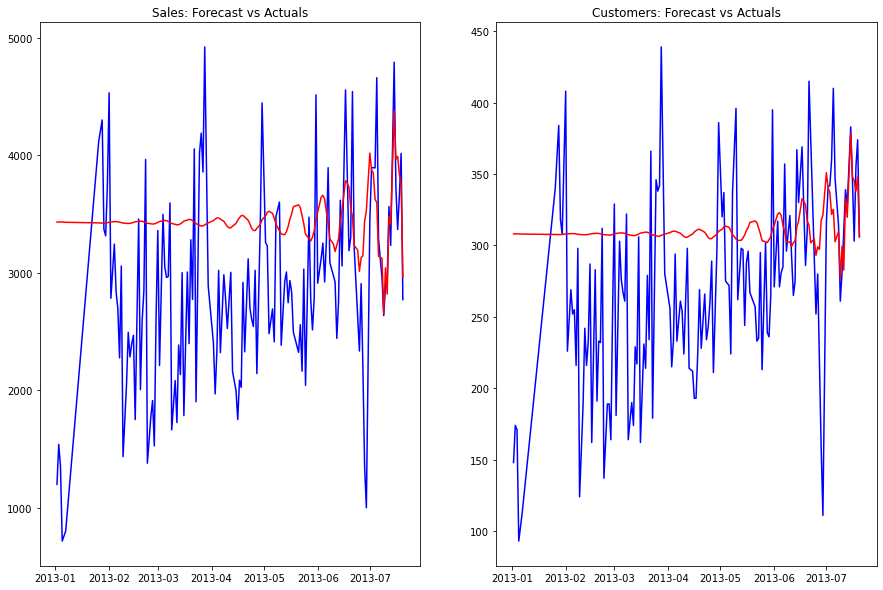

In [128]:
plotForecastVAR(endog_test,df_results)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [129]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [130]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.3866052784410555


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [131]:
forcast ,irf  = callVARMAXModel(endog,exog,endog_test,exog_test,maxiteration =100)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  606
Model:                           VARX(18)   Log Likelihood               -7059.164
Date:                    Mon, 28 Dec 2020   AIC                          14320.327
Time:                            20:38:28   BIC                          14765.422
Sample:                                 0   HQIC                         14493.516
                                    - 606                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            16.05, 3.53   Jarque-Bera (JB):        101.59, 17.17
Prob(Q):                        0.00, 0.06   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.82, 0.69   Skew:                       0.63, 0.12
Prob(H) (two-sided):            0.16, 0.01   Kurtosis:                   4.56, 3.79


### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

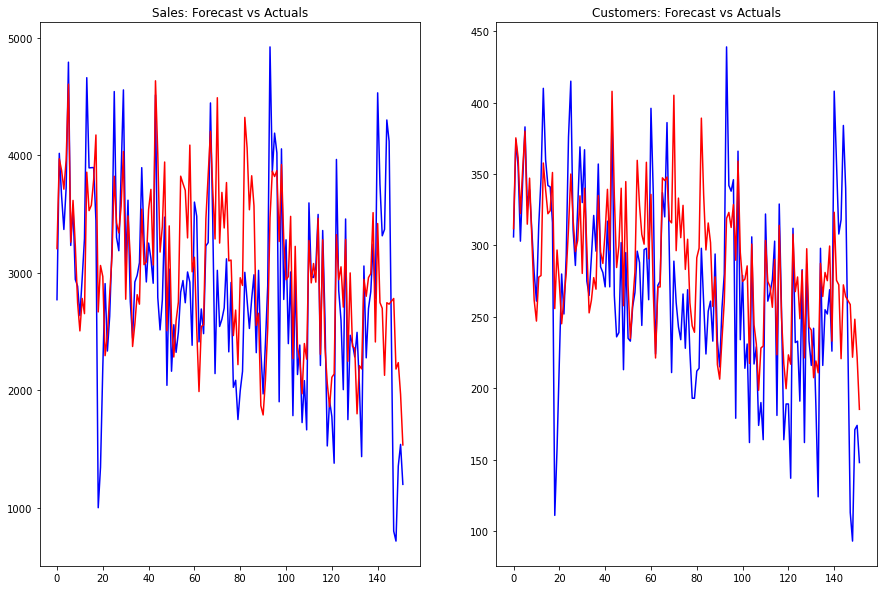

In [132]:
plotForecastVARMAX(endog_test,forcast)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [133]:
report_data= reportVARMAX(endog_test,forcast)
report_data = report_data[report_data.Actual_Sales != 0]

In [134]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

0.2191127470743074


#### Again the MAPE value for the VARMAX model is lot better than the VAR model

## <font color =Green>Running the Process Again for another Store : 453</font>

### <font color =Maroon> Step 1 : Preprocessing the data </font>

In [173]:
### Getting data for one store
storeDataOne = preprocessData(fullData_df,store =453)

In [174]:
len(storeDataOne)

878

In [175]:
### Adding Seasonality and  trends
storeDataOne = addingSeasonalTrends(storeDataOne,view =False)

In [176]:
### Splitting the data into test sets
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataOne)

### <font color =Maroon> Step 2 : Check the Causality </font>

In [140]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [141]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataOne, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


In [142]:
### Since we can see the p-values are less than .05 the Sales is causing Customers and Customers is causing Sales.

### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [143]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  63.56     > 12.3212   =>   True
Customers ::  0.61      > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [144]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1446
 No. Lags Chosen       = 18
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0234. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.032
 No. Lags Chosen       = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.2727. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




### <font color =Maroon>Step 4.1 : Difference the series because of Non-Stationarity</font>

In [177]:
## Diff if needed to be used
endogdiff=endog.diff().dropna()
exogdiff=exog.diff().dropna()
endogdiff_test=endog_test.diff().dropna()
exogdiff_test=exog_test.diff().dropna()

### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [146]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endogdiff,endogdiff_test, notDifferenced=False,oneDifferenced=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     21:35:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    23.3669
Nobs:                     688.000    HQIC:                   23.1487
Log likelihood:          -9814.26    FPE:                9.85391e+09
AIC:                      23.0111    Det(Omega_mle):     9.12375e+09
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -2.068207        71.556250           -0.029           0.977
L1.Sales             -0.922886         0.146136           -6.315           0.000
L1.Customers          0.932038         1.422397            0

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [150]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =False, second_diff=False,first_diff=True) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

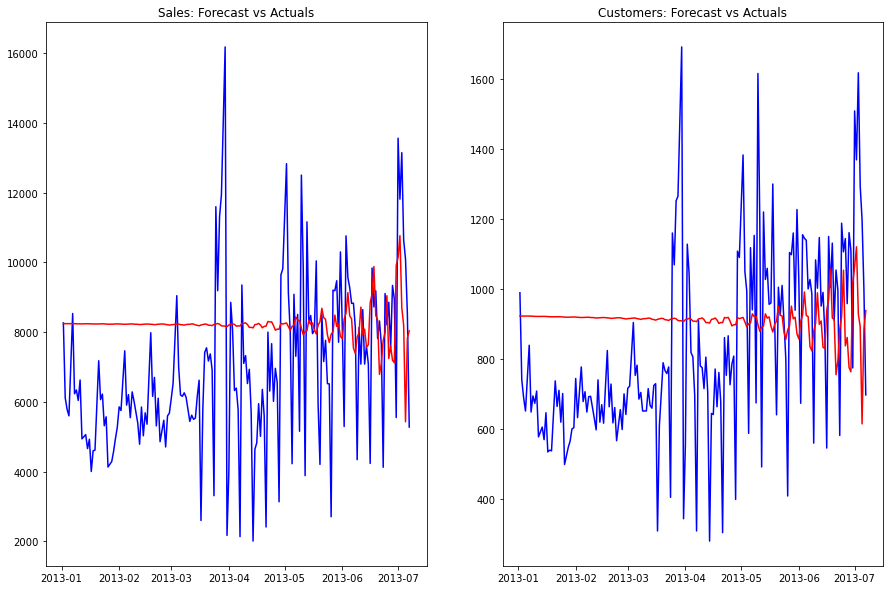

In [154]:
plotForecastVAR(endog_test,df_results)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [155]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [156]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.4208135610944284


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [157]:
forcast ,irf  = callVARMAXModel(endogdiff,exogdiff,endogdiff_test,exogdiff_test,maxiteration =100)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  701
Model:                           VARX(18)   Log Likelihood              -16239.245
Date:                    Mon, 28 Dec 2020   AIC                          32680.490
Time:                            21:46:55   BIC                          33140.294
Sample:                                 0   HQIC                         32858.219
                                    - 701                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):          42.76, 101.94   Jarque-Bera (JB):         23.07, 21.89
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.80, 0.96   Skew:                      0.26, -0.16
Prob(H) (two-sided):            0.08, 0.76   Kurtosis:                   3.72, 3.80


### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [229]:
df_final = invert_transformationVARMAX(endog_test, forcast,no_diff =False , second_diff=False,first_diff=True)

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

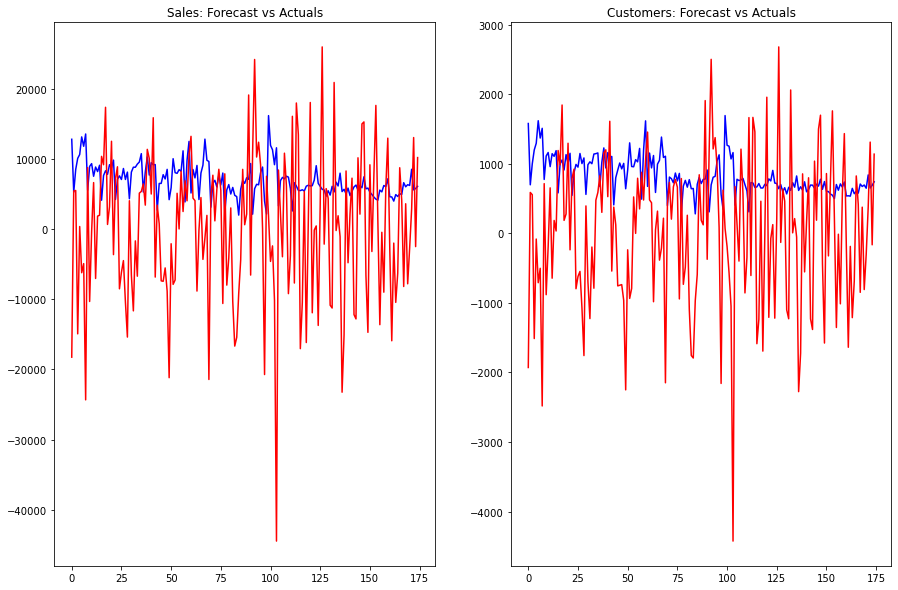

In [230]:
plotForecastVARMAX(endog_test,df_final)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [231]:
report_data= reportVARMAX(endog_test,df_final)
report_data = report_data[report_data.Actual_Sales != 0]

In [232]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

1.5706199624755612


#### For the differenced series the Result from MAPE is off

## <font color =Green>Repeating the steps for another store : 481</font>

### <font color =Maroon> Step 1 : Preprocessing the data </font>

In [233]:
### Getting data for one store
storeDataOne = preprocessData(fullData_df,store =481)

In [234]:
len(storeDataOne)

773

In [235]:
### Adding Seasonality and  trends
storeDataOne = addingSeasonalTrends(storeDataOne,view =False)

In [236]:
### Splitting the data into test sets
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataOne)

### <font color =Maroon> Step 2 : Check the Causality </font>

In [237]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [238]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataOne, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


In [239]:
### Since we can see the p-values are less than .05 the Sales is causing Customers and Customers is causing Sales.

### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [240]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  114.73    > 12.3212   =>   True
Customers ::  0.3       > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [241]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6324
 No. Lags Chosen       = 17
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0865. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1755
 No. Lags Chosen       = 14
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0214. Rejecting Null Hypothesis.
 => Series is Stationary.




### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [242]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endog,endog_test, notDifferenced=True,oneDifferenced=False)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     22:32:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.9508
Nobs:                     600.000    HQIC:                   20.6197
Log likelihood:          -7751.29    FPE:                7.30232e+08
AIC:                      20.4086    Det(Omega_mle):     6.47865e+08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const               558.893460       703.966794            0.794           0.427
L1.Sales              0.155025         0.115352            1.344           0.179
L1.Customers          3.839630         1.781428            2

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [243]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =True, second_diff=False,first_diff=False) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

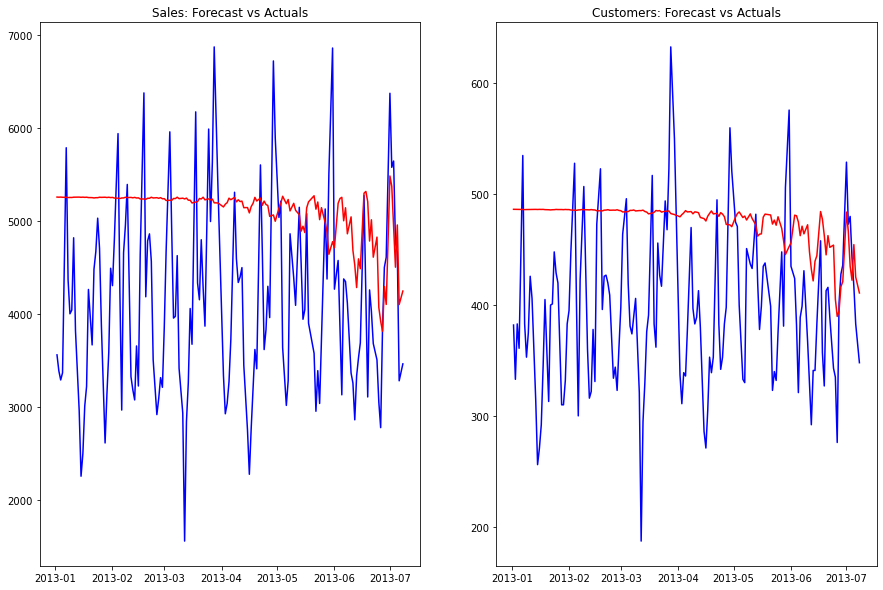

In [244]:
plotForecastVAR(endog_test,df_results)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [245]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [246]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.3538194860049634


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [247]:
forcast ,irf  = callVARMAXModel(endog,exog,endog_test,exog_test,maxiteration =200)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  618
Model:                           VARX(18)   Log Likelihood               -7575.882
Date:                    Mon, 28 Dec 2020   AIC                          15353.764
Time:                            22:37:49   BIC                          15800.840
Sample:                                 0   HQIC                         15527.571
                                    - 618                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             8.91, 3.35   Jarque-Bera (JB):         14.34, 50.35
Prob(Q):                        0.00, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.80, 0.61   Skew:                       0.25, 0.33
Prob(H) (two-sided):            0.12, 0.00   Kurtosis:                   3.56, 4.23


### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

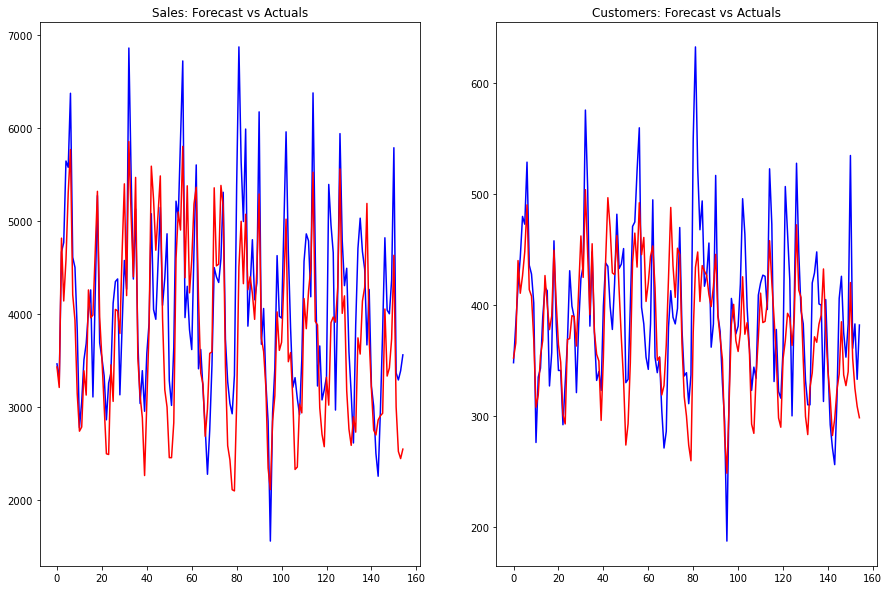

In [248]:
plotForecastVARMAX(endog_test,forcast)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [249]:
report_data= reportVARMAX(endog_test,forcast)
report_data = report_data[report_data.Actual_Sales != 0]

In [250]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

0.14181449291084766


#### This time too we had a weak Non Stationary series and we didnt difference it and the result in VARMAX was better than VAR model and was not completely messed up like the previous store

## <font color =Green>Repeating the steps for another store : 999</font>

### <font color =Maroon> Step 1 : Preprocessing the data </font>

In [283]:
### Getting data for one store
storeDataOne = preprocessData(fullData_df,store = 999)

In [284]:
len(storeDataOne)

772

In [285]:
### Adding Seasonality and  trends
storeDataOne = addingSeasonalTrends(storeDataOne,view =False)

In [286]:
### Splitting the data into test sets
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataOne)

### <font color =Maroon> Step 2 : Check the Causality </font>

In [255]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [256]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataOne, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


In [257]:
### Since we can see the p-values are less than .05 the Sales is causing Customers and Customers is causing Sales.

### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [258]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  141.09    > 12.3212   =>   True
Customers ::  0.02      > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [259]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3204
 No. Lags Chosen       = 16
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7086
 No. Lags Chosen       = 16
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.




### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [260]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endog,endog_test, notDifferenced=True,oneDifferenced=False)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     22:41:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.7185
Nobs:                     605.000    HQIC:                   22.4783
Log likelihood:          -8416.31    FPE:                4.96352e+09
AIC:                      22.3253    Det(Omega_mle):     4.54848e+09
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const              6050.695754      1595.944350            3.791           0.000
L1.Sales              0.568564         0.183644            3.096           0.002
L1.Customers         -7.786401         3.228044           -2

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [261]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =True, second_diff=False,first_diff=False) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

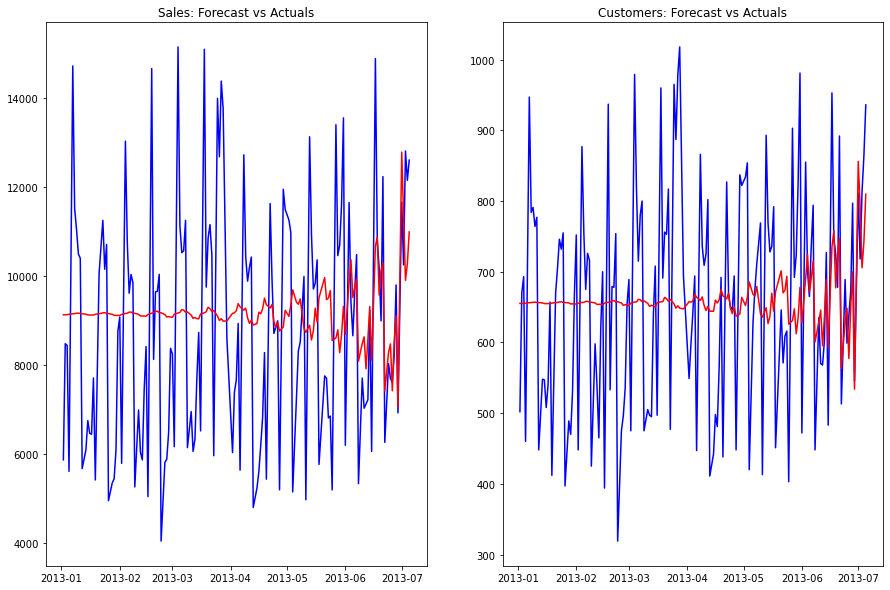

In [262]:
plotForecastVAR(endog_test,df_results)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [263]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [264]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.2788973813916992


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [265]:
forcast ,irf  = callVARMAXModel(endog,exog,endog_test,exog_test,maxiteration =500)

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  618
Model:                           VARX(18)   Log Likelihood               -8235.691
Date:                    Mon, 28 Dec 2020   AIC                          16673.382
Time:                            22:49:40   BIC                          17120.457
Sample:                                 0   HQIC                         16847.188
                                    - 618                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            10.60, 1.18   Jarque-Bera (JB):        103.78, 73.02
Prob(Q):                        0.00, 0.28   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.77, 0.87   Skew:                       0.43, 0.27
Prob(H) (two-sided):            0.07, 0.32   Kurtosis:                   4.81, 4.59


### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

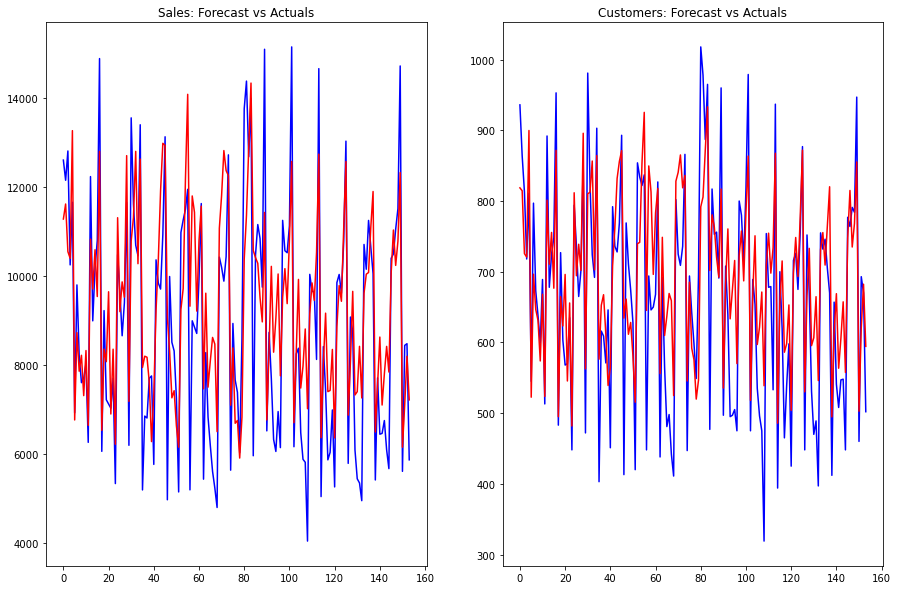

In [266]:
plotForecastVARMAX(endog_test,forcast)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [267]:
report_data= reportVARMAX(endog_test,forcast)
report_data = report_data[report_data.Actual_Sales != 0]

In [268]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

0.1703781807323689


#### Here for the VARMAX model even with more iterations didn't show too much of an improvement.

## <font color =Green>Repeating the steps for another store : 1110</font>

### <font color =Maroon> Step 1 : Preprocessing the data </font>

In [287]:
### Getting data for one store
storeDataOne = preprocessData(fullData_df,store = 1110)

In [288]:
len(storeDataOne)

775

In [289]:
### Adding Seasonality and  trends
storeDataOne = addingSeasonalTrends(storeDataOne,view =False)

In [290]:
### It was mentioned in the Problem descirotion to predict the sale for 6 weeks(42 days) so we are estimating this run for 6 weeks

In [291]:
### Splitting the data into test sets
df_train,df_test ,endog , exog ,endog_test ,exog_test = splitData(storeDataOne,nobs=42)

### <font color =Maroon> Step 2 : Check the Causality </font>

In [292]:
### Variable declarations for causality 
maxlag=12
test = 'ssr_chi2test'

### to extract the series for testing the causality
variables  = ['Sales', 'Customers']

In [293]:
### Calling causation function
### variable is the list of series columns
grangers_causation_matrix(storeDataOne, variables = variables) 

,Sales_x,Customers_x
Sales_y,1.0,0.0
Customers_y,0.0,1.0


In [294]:
### Since we can see the p-values are less than .05 the Sales is causing Customers and Customers is causing Sales.

### <font color =Maroon>Step 3 : Johannsen Cointegration test </font>

In [295]:
### calling the cointegration test
cointegration_test(endog)

Name   ::  Test Stat > C(95%)    =>   Signif  
 --------------------------------------------------
Sales  ::  222.91    > 12.3212   =>   True
Customers ::  0.05      > 4.1296    =>   False


### <font color =Maroon>Step 4 : Check for Stationarity:  ADF Test</font>

In [296]:
# We are only passing the two series(Sales and Customer) for this test based on the various test runs done before.
for name, column in endog.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9913
 No. Lags Chosen       = 12
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5675
 No. Lags Chosen       = 12
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.




### <font color =Maroon>Step 5 : Call the VAR Model</font>

In [297]:
### Calling with endog variables as the series was stationary
df_forecast =callVARModel(endog,endog_test, notDifferenced=True,oneDifferenced=False)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     23:53:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.8107
Nobs:                     718.000    HQIC:                   20.5681
Log likelihood:          -9304.78    FPE:                7.35205e+08
AIC:                      20.4156    Det(Omega_mle):     6.75607e+08
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                93.279365       696.078580            0.134           0.893
L1.Sales              0.173594         0.137309            1.264           0.206
L1.Customers          1.175702         1.552025            0

### <font color =Maroon>Step 6: Invert the transformation and store the predicted results on the Test set</font>

In [298]:
df_results = invert_transformation(endog_test, df_forecast,no_diff =True, second_diff=False,first_diff=False) 

### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

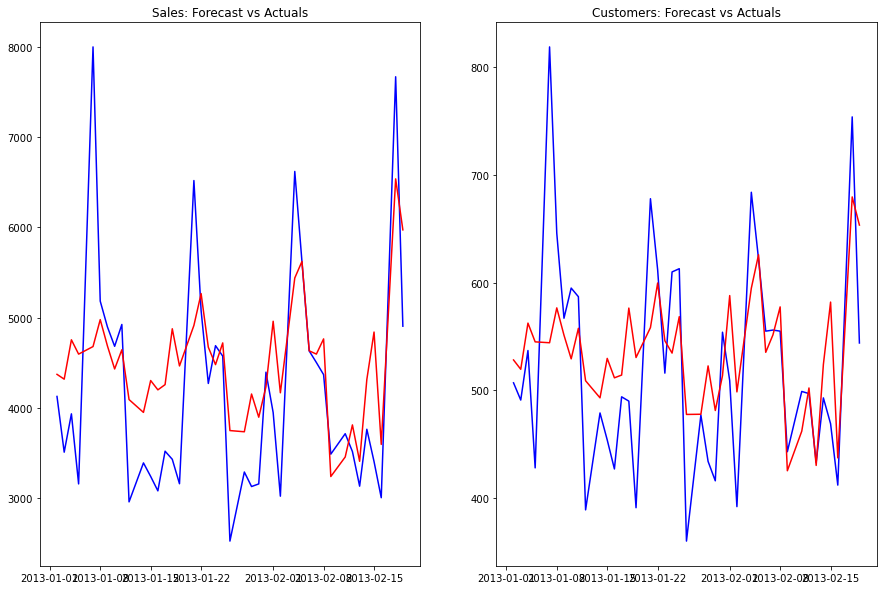

In [299]:
plotForecastVAR(endog_test,df_results)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [300]:
reportData = reportVAR(endog_test,df_results)
reportData = reportData[reportData.Actual_Sales != 0]

In [301]:
MAPE=np.mean(abs(reportData.Actual_Sales-reportData.Sales)/(reportData.Actual_Sales))
print(MAPE)

0.18801528860674122


### <font color =Maroon>Step 5.1 : Call the VARMAX Model</font>

In [303]:
forcast ,irf  = callVARMAXModel(endog,exog,endog_test,exog_test,maxiteration =100)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  733
Model:                           VARX(18)   Log Likelihood               -9014.920
Date:                    Tue, 29 Dec 2020   AIC                          18231.839
Time:                            00:15:20   BIC                          18696.151
Sample:                                 0   HQIC                         18410.940
                                    - 733                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            13.07, 0.00   Jarque-Bera (JB):          81.09, 7.70
Prob(Q):                        0.00, 0.95   Prob(JB):                   0.00, 0.02
Heteroskedasticity (H):         0.69, 0.77   Skew:                       0.39, 0.07
Prob(H) (two-sided):            0.00, 0.04   Kurtosis:                   4.43, 3.48


### <font color =Maroon>Step 7 : Plotting the forecasted vs actuals</font>

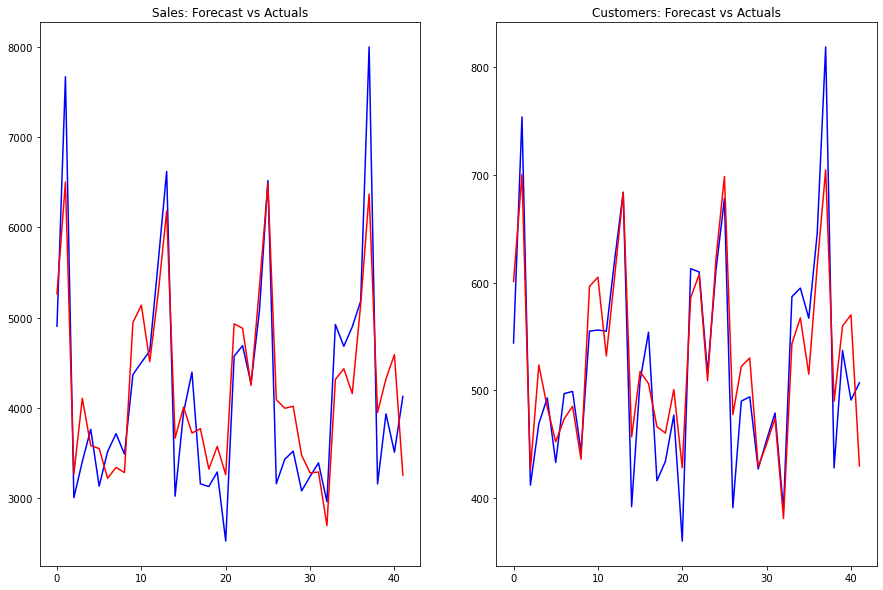

In [304]:
plotForecastVARMAX(endog_test,forcast)

### <font color =Maroon>Step 8 : Find the MAPE</font>

In [305]:
report_data= reportVARMAX(endog_test,forcast)
report_data = report_data[report_data.Actual_Sales != 0]

In [306]:
MAPE=np.mean(abs(report_data.Actual_Sales-report_data.Sales)/(report_data.Actual_Sales))
print(MAPE)

0.11519424962206976


#### So as seen before the VARMAX model performed better than VAR model , but it took more time to execute because of the extra training data.

# Conclusion 

### In General the VARMAX model was outperforming the VAR model and we were able to give a lot better prediction of Sales and Customers from it.
### We tried training the data on traditional split of 80/20 as well as the requested format of 6 weeks prediction and the latter gave more accuracy.
